# Set-up

In [1]:
from typing import List, Callable, Tuple, TypeVar, Iterator
import matplotlib.pyplot as plt
import random
import math

# Example - Perlin noise

https://jackmckew.dev/3d-gradient-descent-in-python.html

In [2]:
import noise
import numpy as np
import matplotlib.pyplot
from mpl_toolkits.mplot3d import axes3d
import plotly
import plotly.graph_objects as go
from IPython.core.display import HTML
import numpy as np
from numpy.lib.stride_tricks import as_strided
from dataclasses import dataclass

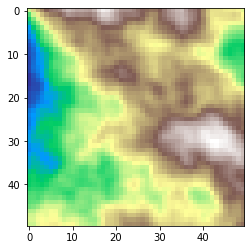

In [3]:
shape = (50,50)
scale = 100.0
octaves = 6
persistence = 0.5
lacunarity = 2.0

world = np.zeros(shape)
for i in range(shape[0]):
    for j in range(shape[1]):
        world[i][j] = noise.pnoise2(i/scale, 
                                    j/scale, 
                                    octaves=octaves, 
                                    persistence=persistence, 
                                    lacunarity=lacunarity, 
                                    repeatx=1024, 
                                    repeaty=1024, 
                                    base=42)
        
matplotlib.pyplot.imshow(world,cmap='terrain')

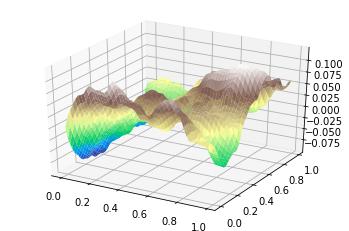

In [4]:
lin_x = np.linspace(0,1,shape[0],endpoint=False)
lin_y = np.linspace(0,1,shape[1],endpoint=False)
x,y = np.meshgrid(lin_x,lin_y)

fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(x,y,world,cmap='terrain')

In [5]:
terrain_cmap = matplotlib.cm.get_cmap('terrain')
def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return pl_colorscale

terrain = matplotlib_to_plotly(terrain_cmap, 255)


plotly.offline.init_notebook_mode(connected=True)

fig = go.Figure(data=[go.Surface(colorscale=terrain,z=world)])

fig.update_layout(title='Random 3D Terrain')

# Note that include_plotlyjs is used as cdn so that the static site generator can read it and present it on the browser. This is not typically required.
html = plotly.offline.plot(fig, filename='3d-terrain-plotly.html',include_plotlyjs='cdn')

HTML(html)

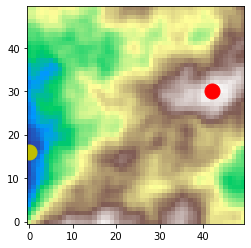

In [6]:
z = world
matplotlib.pyplot.imshow(z,origin='lower',cmap='terrain')

# Find maximum value index in numpy array
indices = np.where(z == z.max())
max_z_x_location, max_z_y_location = (indices[1][0],indices[0][0])
matplotlib.pyplot.plot(max_z_x_location,max_z_y_location,'ro',markersize=15)

# Find minimum value index in numpy array
indices = np.where(z == z.min())
min_z_x_location, min_z_y_location = (indices[1][0],indices[0][0])
matplotlib.pyplot.plot(min_z_x_location,min_z_y_location,'yo',markersize=15)

In [7]:
def sliding_window(arr, window_size):
    """ Construct a sliding window view of the array"""
    arr = np.asarray(arr)
    window_size = int(window_size)
    if arr.ndim != 2:
        raise ValueError("need 2-D input")
    if not (window_size > 0):
        raise ValueError("need a positive window size")
    shape = (arr.shape[0] - window_size + 1,
             arr.shape[1] - window_size + 1,
             window_size, window_size)
    if shape[0] <= 0:
        shape = (1, shape[1], arr.shape[0], shape[3])
    if shape[1] <= 0:
        shape = (shape[0], 1, shape[2], arr.shape[1])
    strides = (arr.shape[1]*arr.itemsize, arr.itemsize,
               arr.shape[1]*arr.itemsize, arr.itemsize)
    return as_strided(arr, shape=shape, strides=strides)

def cell_neighbours(arr, i, j, d):
    """Return d-th neighbors of cell (i, j)"""
    w = sliding_window(arr, 2*d+1)

    ix = np.clip(i - d, 0, w.shape[0]-1)
    jx = np.clip(j - d, 0, w.shape[1]-1)

    i0 = max(0, i - d - ix)
    j0 = max(0, j - d - jx)
    i1 = w.shape[2] - max(0, d - i + ix)
    j1 = w.shape[3] - max(0, d - j + jx)

    return w[ix, jx][i0:i1,j0:j1].ravel()

In [8]:
@dataclass
class descent_step:
    """Class for storing each step taken in gradient descent"""
    value: float
    x_index: float
    y_index: float

def gradient_descent_3d(array,x_start,y_start,steps=50,step_size=1,plot=False):
    # Initial point to start gradient descent at
    step = descent_step(array[y_start][x_start],x_start,y_start)
    
    # Store each step taken in gradient descent in a list
    step_history = []
    step_history.append(step)
    
    # Plot 2D representation of array with startng point as a red marker
    if plot:
        matplotlib.pyplot.imshow(array,origin='lower',cmap='terrain')
        matplotlib.pyplot.plot(x_start,y_start,'ro')
    current_x = x_start
    current_y = y_start

    # Loop through specified number of steps of gradient descent to take
    for i in range(steps):
        prev_x = current_x
        prev_y = current_y
        
        # Extract array of neighbouring cells around current step location with size nominated
        neighbours=cell_neighbours(array,current_y,current_x,step_size)
        
        # Locate minimum in array (steepest slope from current point)
        next_step = neighbours.min()
        indices = np.where(array == next_step)
        
        # Update current point to now be the next point after stepping
        current_x, current_y = (indices[1][0],indices[0][0])
        step = descent_step(array[current_y][current_x],current_x,current_y)
        
        step_history.append(step)
        
        # Plot each step taken as a black line to the current point nominated by a red marker
        if plot:
            matplotlib.pyplot.plot([prev_x,current_x],[prev_y,current_y],'k-')
            matplotlib.pyplot.plot(current_x,current_y,'ro')
            
        # If step is to the same location as previously, this infers convergence and end loop
        if prev_y == current_y and prev_x == current_x:
            print(f"Converged in {i} steps")
            break
    return next_step,step_history

Target: -0.0994970053434372 @ (array([16]), array([0]))
Converged in 9 steps
Converged in 5 steps
Converged in 7 steps
Converged in 6 steps
Converged in 4 steps
Converged in 4 steps
Converged in 3 steps
Converged in 3 steps
Converged in 3 steps
Converged in 5 steps
Optimal step size 10
Converged in 5 steps
Steps: [descent_step(value=0.10347005724906921, x_index=38, y_index=28), descent_step(value=0.007558110170066357, x_index=28, y_index=38), descent_step(value=-0.03461135923862457, x_index=18, y_index=39), descent_step(value=-0.03682023286819458, x_index=8, y_index=35), descent_step(value=-0.07587684690952301, x_index=0, y_index=26), descent_step(value=-0.0994970053434372, x_index=0, y_index=16), descent_step(value=-0.0994970053434372, x_index=0, y_index=16)]


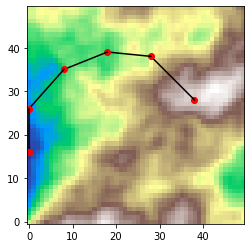

In [9]:
np.random.seed(42)
global_minimum = z.min()
indices = np.where(z == global_minimum)
print(f"Target: {global_minimum} @ {indices}")

step_size = 0
found_minimum = 99999

# Random starting point
start_x = np.random.randint(0,50)
start_y = np.random.randint(0,50)

# Increase step size until convergence on global minimum
while found_minimum != global_minimum:
    step_size += 1
    found_minimum,steps = gradient_descent_3d(z,start_x,start_y,step_size=step_size,plot=False)

print(f"Optimal step size {step_size}")
found_minimum,steps = gradient_descent_3d(z,start_x,start_y,step_size=step_size,plot=True)
print(f"Steps: {steps}")

In [10]:
def multiDimenDist(point1,point2):
   #find the difference between the two points, its really the same as below
   deltaVals = [point2[dimension]-point1[dimension] for dimension in range(len(point1))]
   runningSquared = 0
   #because the pythagarom theorm works for any dimension we can just use that
   for coOrd in deltaVals:
       runningSquared += coOrd**2
   return runningSquared**(1/2)
def findVec(point1,point2,unitSphere = False):
  #setting unitSphere to True will make the vector scaled down to a sphere with a radius one, instead of it's orginal length
  finalVector = [0 for coOrd in point1]
  for dimension, coOrd in enumerate(point1):
      #finding total differnce for that co-ordinate(x,y,z...)
      deltaCoOrd = point2[dimension]-coOrd
      #adding total difference
      finalVector[dimension] = deltaCoOrd
  if unitSphere:
      totalDist = multiDimenDist(point1,point2)
      unitVector =[]
      for dimen in finalVector:
          unitVector.append( dimen/totalDist)
      return unitVector
  else:
      return finalVector

In [11]:
def generate_3d_plot(step_history):
    # Initialise empty lists for markers
    step_markers_x = []
    step_markers_y = []
    step_markers_z = []
    step_markers_u = []
    step_markers_v = []
    step_markers_w = []
    
    for index, step in enumerate(step_history):
        step_markers_x.append(step.x_index)
        step_markers_y.append(step.y_index)
        step_markers_z.append(step.value)
        
        # If we haven't reached the final step, calculate the vector between the current step and the next step
        if index < len(steps)-1:
            vec1 = [step.x_index,step.y_index,step.value]
            vec2 = [steps[index+1].x_index,steps[index+1].y_index,steps[index+1].value]

            result_vector = findVec(vec1,vec2)
            step_markers_u.append(result_vector[0])
            step_markers_v.append(result_vector[1])
            step_markers_w.append(result_vector[2])
        else:
            step_markers_u.append(0.1)
            step_markers_v.append(0.1)
            step_markers_w.append(0.1)
    
    # Include cones at each marker to show direction of step, scatter3d is to show the red line between points and surface for the terrain
    fig = go.Figure(data=[
        go.Cone(
        x=step_markers_x,
        y=step_markers_y,
        z=step_markers_z,
        u=step_markers_u,
        v=step_markers_v,
        w=step_markers_w,
        sizemode="absolute",
        sizeref=2,
        anchor='tail'),

        go.Scatter3d(
        x=step_markers_x,
        y=step_markers_y,
        z=step_markers_z,
        mode='lines',
        line=dict(
            color='red',
            width=2
        )),

        go.Surface(colorscale=terrain,z=world,opacity=0.5)])


    # Z axis is limited to the extent of the terrain array
    fig.update_layout(
        title='Gradient Descent Steps',
        scene = dict(zaxis = dict(range=[world.min(),world.max()],),),)
    return fig
    
# Generate 3D plot from previous random starting location
fig = generate_3d_plot(steps)
HTML(plotly.offline.plot(fig, filename='random_starting_point_3d_gradient_descent.html',include_plotlyjs='cdn'))

Converged in 3 steps


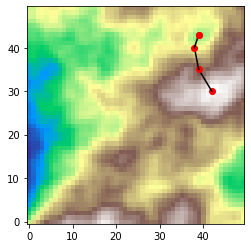

In [12]:
found_minimum,steps = gradient_descent_3d(z,max_z_x_location,max_z_y_location,step_size=5,plot=True)
fig = generate_3d_plot(steps)
HTML(plotly.offline.plot(fig, filename='maximum_starting_point_step_size_5_3d_gradient_descent.html',include_plotlyjs='cdn'))

# Concept

In [13]:
def dot(v: List[float], w: List[float]) -> float:
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v: List[float]) -> float:
    '''Computes the sum of squared elements in v'''
    return dot(v, v)

# Estimate the gradient

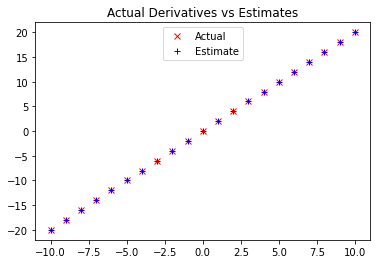

In [14]:
def difference_quotient(f: Callable[[float], float], x: float, h: float) -> float:
    return (f(x + h) - f(x)) / h

def square(x: float) -> float:
    return x * x

def derivative(x: float) -> float:
    return 2 * x

xs = range(-10, 11)
actuals = [derivative(x) for x in xs]
estimates = [difference_quotient(square, x, h = 0.001) for x in xs]

plt.plot(xs, actuals, 'rx', label = 'Actual')
plt.plot(xs, estimates, 'b+', label = 'Estimate')
plt.title('Actual Derivatives vs Estimates')
plt.legend(loc = 9)
plt.show()

In [15]:
def partial_difference_quotient(f: Callable[[List[float]], float], 
                                v: List[float],
                                i: int,
                                h: float) -> float:
    '''Returns the i-th partial difference quotient of f at v'''
    w = [v_j + (h if j == i else 0)
         for j, v_j in enumerate(v)]
    return (f(w) - f(v)) / h

def estimate_gradient(f: Callable[[List[float]], float],
                      v: List[float],
                      h: float = 0.0001):
    return [partial_difference_quotient(f, v, i, h)
            for i in range(len(v))]

# Use the gradient

In [16]:
def add(v: List[float], w: List[float]) -> List[float]:
    """Adds corresponding elements"""
    assert len(v) == len(w), "vectors must be the same length"
    return [v_i + w_i for v_i, w_i in zip(v, w)]

def vector_sum(vectors: List[List[float]]) -> List[float]:
    """Sums all corresponding elements"""
    num_elements = len(vectors[0])
    assert all(len(v) == num_elements for v in vectors), "different sizes!"

    return [sum(vector[i] for vector in vectors)
            for i in range(num_elements)]

def vector_mean(vectors: List[List[float]]) -> List[float]:
    """Computes the element-wise average"""
    n = len(vectors)
    return scalar_multiply(1/n, vector_sum(vectors))

def scalar_multiply(c: float, v: List[float]) -> List[float]:
    """Multiplies every element by c"""
    return [c * v_i for v_i in v]

def subtract(v: List[float], w: List[float]) -> List[float]:
    """Subtracts corresponding elements"""
    assert len(v) == len(w), "vectors must be the same length"
    return [v_i - w_i for v_i, w_i in zip(v, w)]

def dot(v: List[float], w: List[float]) -> float:
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v: List[float]) -> float:
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def squared_distance(v: List[float], w: List[float]) -> float:
    """Computes (v_1 - w_1) ** 2 + ... + (v_n - w_n) ** 2"""
    return sum_of_squares(subtract(v, w))

def distance(v: List[float], w: List[float]) -> float:
    """Computes the distance between v and w"""
    return math.sqrt(squared_distance(v, w))

In [17]:
def gradient_step(v: List[float], gradient: List[float], step_size = float) -> List[float]:
    '''Moves step_size in the gradient direction from v'''
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    return add(v, step)

def sum_of_squares_gradient(v: List[float]) -> List[float]:
    return [2 * v_i for v_i in v]

In [18]:
v = [random.uniform(-10, 10) for i in range(3)]
v

[-5.634651082727271, -4.929324601105121, 3.027231201110556]

In [19]:
for epoch in range(1000):
    grad = sum_of_squares_gradient(v)
    v = gradient_step(v, grad, -0.01)

assert distance(v, [0,0,0]) < 0.001

# Choose the step size

- Using a fixed step size
- Gradually shrinking the step size over time
- At each step, choosing the step size that minimizes the value of the objective function

# Fit models

In [20]:
# Simulate linear regression data 
inputs = [(x, 20 * x + 5) for x in range(-10, 50)]

# Define linear regression gradient 
def linear_gradient(x: float, y: float, theta: List[float]) -> List[float]:
    slope, intercept = theta
    predicted = slope * x + intercept
    error = (predicted - y)
    squared_error = error ** 2
    grad = [2 * error * x, 2 * error]
    return grad

# Start with a random value for theta 
theta = [random.uniform(-1, 1), random.uniform(-1, 1)]
learning_rate = 0.001

for epoch in range(5000):
    # Compute the mean of the gradients
    grad = vector_mean([linear_gradient(x, y, theta) for x, y in inputs])
    # Take a step in that direction
    theta = gradient_step(theta, grad, -learning_rate)
    
slope, intercept = theta
slope, intercept

(20.001733164531142, 4.939585787781034)

# Minibatch

In [21]:
T = TypeVar('T')

def minibatches(dataset: List[T],
                batch_size = int,
                shuffle: bool = True) -> Iterator[List[T]]:
    '''Generates batch_size minibatches from the dataset'''
    batch_starts = [start for start in range(0, len(dataset), batch_size)]
    
    if shuffle: 
        random.shuffle(batch_starts)
    for start in batch_starts:
        end = start + batch_size 
        yield dataset[start:end]

In [22]:
theta = [random.uniform(-1, 1), random.uniform(-1, 1)]

for epoch in range(1000):
    for batch in minibatches(inputs, batch_size = 20):
        grad = vector_mean([linear_gradient(x, y, theta) for x, y in batch])
        theta = gradient_step(theta, grad, -learning_rate)

slope, intercept = theta
slope, intercept

(20.017261618259504, 4.681644554895503)

# Stochastic 

In [23]:
theta = [random.uniform(-1, 1), random.uniform(-1, 1)]

for epoch in range(100):
    for x, y in inputs:
        grad = linear_gradient(x, y, theta)
        theta = gradient_step(theta, grad, -learning_rate)

slope, intercept = theta
slope, intercept

(20.001853224653917, 4.9077418762187115)